In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import folium
import fontawesome as fa
from folium.plugins import BeautifyIcon
from shapely.geometry import Polygon, LineString, Point
import openrouteservice as ors
from openrouteservice import client
import time
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from shapely.ops import cascaded_union


spark = (
    SparkSession.builder.appName("Assignment_2")
    .config("spark.sql.repl.eagerEval.enabled", True)
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .getOrCreate()
)
pd.options.display.float_format = "{:,.4f}".format
FIG_PATH = f"../plots/"
INPUT_PATH = f"../data/raw/"
# GIT
TOKEN = "5b3ce3597851110001cf62483f8783dee87f49d1a08c14865546e9d5"
ors_client = client.Client(key=TOKEN)
SLEEP_TIME = 3.1
params_route = {'profile': 'driving-car',
            'format_out': 'geojson',
            'geometry': 'true',
            'format': 'geojson',
            'instructions': 'false'
            }
## CBD center coordinates can be found in path finding
CBD = (-37.813612, 144.96257)


## Median rent by sa2 AND Point of Interests

In [ ]:
## load rent data
rent_df = pd.read_csv(f"../data/raw/DHHS/history_rent.csv")
rent_df = rent_df[(rent_df["year"] == 2021) & (rent_df["quarter"] == 1)]
rent_df = rent_df.drop(["year", "quarter", "index"], axis=1).reset_index(drop=True)

print(rent_df.shape)
print(rent_df.head())

(501, 3)
         SA2  count      median
0  201011001   1004  387.500000
1  201011002    968  350.000000
2  201011005   1138  385.000000
3  201011006   1004  387.500000
4  201011007   1020  354.333333


In [ ]:
## get school location
foi_gdf = gpd.read_file(f"../data/raw/FOI/ll_gda2020/esrishape/whole_of_dataset/victoria/VMFEAT/FOI_POINT.shp")
boundary_gdf = gpd.read_file(f"../data/raw/ABS/digitalBoundary/SA2_2021_AUST_GDA2020.shp")
# foi_gdf.to_csv("../data/raw/FOI_raw.csv")

## feature selection for foi
foi_gdf = foi_gdf[["PARENTFTID", "FTYPE", "NAME_LABEL", "geometry"]]
foi_gdf = foi_gdf.loc[foi_gdf["PARENTFTID"].isna()].drop(["PARENTFTID"], axis=1).dropna().drop_duplicates()
foi_gdf = foi_gdf.query("FTYPE == 'commercial facility' | FTYPE == 'Recreational resource'")
foi_gdf = foi_gdf.drop(columns="FTYPE").rename({"NAME_LABEL": "name"}, axis=1)
foi_gdf["geometry"] = foi_gdf["geometry"].centroid

print(foi_gdf.shape)
print(foi_gdf.head())

(58, 2)
                   name                     geometry
2373       Lardner Park  POINT (145.86461 -38.20123)
2530  Pivotonian Cinema  POINT (144.35587 -38.15878)
3254    Midland Theatre  POINT (142.93462 -37.28425)
3255      Globe Theatre  POINT (143.99244 -38.23934)
3256    Horsham Theatre  POINT (142.20090 -36.71568)


/tmp/ipykernel_258/193562452.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  foi_gdf["geometry"] = foi_gdf["geometry"].centroid


In [ ]:
## get school location
school_df = pd.read_excel(
    f"../data/raw/ACARA/School_location_raw.xlsx",
    sheet_name="SchoolLocations 2021",
)[["School Name", "State", "Latitude", 
    "Longitude", "School Type"]]

## feature selection for school
school_df = school_df.loc[school_df["School Type"] != "Special"]
school_df = school_df.loc[school_df["State"] == "VIC"]
school_df = school_df.drop(columns=["State", "School Type"])
school_df = school_df.dropna().drop_duplicates()

school_gdf = gpd.GeoDataFrame(school_df, geometry=gpd\
            .points_from_xy(school_df["Longitude"], school_df["Latitude"])).dropna()
school_gdf = school_gdf.drop(columns=["Latitude", "Longitude"]).rename({"School Name": "name"}, axis=1)
school_gdf["geometry"] = school_gdf["geometry"].centroid
print(school_gdf.shape)
print(school_gdf.head())

(2728, 2)
                                    name                     geometry
241   Kurnai College - University Campus  POINT (146.42488 -38.30939)
295         Learning Co-Operative School  POINT (145.21333 -37.62939)
297                        Andale School  POINT (145.03604 -37.80551)
298                 The Currajong School  POINT (145.05995 -37.87595)
299  Mansfield Autism Statewide Services  POINT (146.08586 -37.06080)


In [ ]:
## get station data
output_dir = "../data/raw/PTV/ll_gda2020/esrishape/whole_of_dataset/victoria/PUBLIC_TRANSPORT/"
stop_gdf = gpd.GeoDataFrame(columns=["STOP_NAME"])
file_paths = [
    f"{output_dir}PTV_METRO_TRAIN_STATION.shp",
    f"{output_dir}PTV_REGIONAL_TRAIN_STATION.shp",
    f"{output_dir}PTV_SKYBUS_STOP.shp"
]

for file_path in file_paths:
    cur_gdf = gpd.read_file(file_path)[["STOP_NAME", "geometry"]]
    stop_gdf = pd.concat([stop_gdf, cur_gdf])

stop_gdf = stop_gdf.rename(columns={"STOP_NAME": "name"})
stop_gdf["geometry"] = stop_gdf["geometry"].centroid
print(stop_gdf.shape)
print(stop_gdf.head())

(334, 2)
                                                name  \
0             Royal Park Railway Station (Parkville)   
1  Flemington Bridge Railway Station (North Melbo...   
2         Macaulay Railway Station (North Melbourne)   
3   North Melbourne Railway Station (West Melbourne)   
4        Clifton Hill Railway Station (Clifton Hill)   

                      geometry  
0  POINT (144.95231 -37.78118)  
1  POINT (144.93933 -37.78813)  
2  POINT (144.93617 -37.79425)  
3  POINT (144.94258 -37.80741)  
4  POINT (144.99542 -37.78864)  


In [ ]:
point_gdf = pd.concat([foi_gdf, school_gdf])
point_gdf["geometry"] = point_gdf["geometry"].centroid

print(point_gdf.shape)
print(point_gdf.head())

(2786, 2)
                   name                     geometry
2373       Lardner Park  POINT (145.86461 -38.20123)
2530  Pivotonian Cinema  POINT (144.35587 -38.15878)
3254    Midland Theatre  POINT (142.93462 -37.28425)
3255      Globe Theatre  POINT (143.99244 -38.23934)
3256    Horsham Theatre  POINT (142.20090 -36.71568)


/tmp/ipykernel_258/1539881919.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  point_gdf["geometry"] = point_gdf["geometry"].centroid


In [ ]:
# read load zone/shape data
boundary_gdf = gpd.read_file("../data/raw/ABS/digitalBoundary/SA2_2021_AUST_GDA2020.shp")

# feature engineering for boundary
boundary_gdf = boundary_gdf.dropna().drop_duplicates()
boundary_gdf = boundary_gdf.loc[boundary_gdf["STE_NAME21"] == "Victoria"]
boundary_gdf["SA2_CODE21"] = boundary_gdf["SA2_CODE21"].astype(int)
boundary_gdf = boundary_gdf.rename(columns={"SA2_CODE21": "SA2"})
boundary_gdf = boundary_gdf[["SA2", "geometry"]].drop_duplicates()


In [ ]:
geoJSON = boundary_gdf.dropna().drop_duplicates().to_json()

base_map = folium.Map(location=[-37.8, 145],
    tiles="Stamen Terrain", zoom_start=12)
base_map.add_child(folium.Choropleth(geo_data=geoJSON,
                                    name="choropleth"))

top_map = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=rent_df, # data source
    columns=['SA2','median'], # the columns required
    key_on='properties.SA2', # this is from the geoJSON's properties
    fill_color='YlGn', # color scheme
    nan_fill_color='black',
    legend_name='MN'
)
top_map.add_to(base_map)


for coord in zip(foi_gdf["geometry"].y, foi_gdf["geometry"].x):
    base_map.add_child(folium.Marker(location=coord, icon=folium.Icon(color='gray',
                                       icon_color='#660000',
                                       icon='fa-solid fa-flag',
                                       prefix='fa',
                                       )))

for coord in zip(school_gdf["geometry"].y, school_gdf["geometry"].x):
    base_map.add_child(folium.Marker(location=coord, icon=folium.Icon(color='lightgray',
                                       icon_color='#0066CC',
                                       icon='fa-solid fa-book',
                                       prefix='fa',
                                       )))

for coord in zip(stop_gdf["geometry"].y, stop_gdf["geometry"].x):
    base_map.add_child(folium.Marker(location=coord, icon=folium.Icon(color='white',
                                       icon_color='#0000CC',
                                       icon='fa-solid fa-train',
                                       prefix='fa',
                                       )))


# for name, geometry in point_gdf[["name", "geometry"]].values:
#     geometry = [geometry.x , geometry.y]
#     base_map.add_child(folium.Marker(location=geometry,tooltip=name, popup=name))
#     base_map.add_child(folium.Marker(location=geometry,
#         tooltip=name,
#         icon=folium.DivIcon(html=f"<b><I>{name}</I></b>",
#             class_name="mapText"),
#     ))


base_map.save(f"{FIG_PATH}Median_Rent_Choropleth.html")

### Top 10 high rent

In [29]:
# read load zone/shape data
boundary_gdf = gpd.read_file("../data/raw/ABS/digitalBoundary/SA2_2021_AUST_GDA2020.shp")

# feature engineering for boundary
boundary_gdf = boundary_gdf.dropna().drop_duplicates()
boundary_gdf = boundary_gdf.loc[boundary_gdf["STE_NAME21"] == "Victoria"]
boundary_gdf["SA2_CODE21"] = boundary_gdf["SA2_CODE21"].astype(int)
boundary_gdf = boundary_gdf.rename(columns={"SA2_CODE21": "SA2"})
boundary_gdf = boundary_gdf[["SA2", "geometry"]].drop_duplicates()

## load rent data
rent_df = pd.read_csv(f"../data/raw/DHHS/history_rent.csv")
rent_df = rent_df[(rent_df["year"] == 2021) & (rent_df["quarter"] == 1)]
rent_df = rent_df.drop(["year", "quarter", "index"], axis=1).reset_index(drop=True)
top_df = rent_df.sort_values("median", ascending=False).head(10)
top_df = top_df.merge(boundary_gdf, how="left")
top_gdf = gpd.GeoDataFrame(top_df)
top_gdf["geometry"] = top_gdf["geometry"].centroid

print(rent_df.shape)
print(top_gdf.head())

(501, 3)
         SA2  count   median                     geometry
0  203031049    235 500.0000  POINT (144.01959 -38.44191)
1  210021233    157 470.0000  POINT (144.57326 -37.41192)
2  203031489   2044 450.0000  POINT (144.41961 -38.25643)
3  207021424    756 450.0000  POINT (145.16926 -37.76943)
4  203021485   2044 450.0000  POINT (144.36003 -38.21566)


/tmp/ipykernel_216/2250293188.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  top_gdf["geometry"] = top_gdf["geometry"].centroid


In [30]:
geoJSON = boundary_gdf.dropna().drop_duplicates().to_json()

base_map = folium.Map(location=[-37.8, 145],
    tiles="Stamen Terrain", zoom_start=12)
base_map.add_child(folium.Choropleth(geo_data=geoJSON,
                                    name="choropleth"))

top_map = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=rent_df, # data source
    columns=['SA2','median'], # the columns required
    key_on='properties.SA2', # this is from the geoJSON's properties
    fill_color='YlGn', # color scheme
    nan_fill_color='black',
    legend_name='MN'
)
top_map.add_to(base_map)



for coord in zip(top_gdf["geometry"].y, top_gdf["geometry"].x):
    base_map.add_child(folium.Marker(location=coord, icon=folium.Icon(color='white',
                                       icon_color='#660000',
                                       prefix='fa',
                                       )))

base_map.add_child(folium.Marker(location=CBD, icon=folium.Icon(color='lightgray',
                                    icon_color='#0066CC',
                                    icon='fa-solid fa-flag',
                                    prefix='fa',
                                    )))

base_map.save(f"{FIG_PATH}Top_10_rent.html")

## Population ON SA2

In [ ]:
# read load zone/shape data
boundary_gdf = gpd.read_file("../data/raw/ABS/digitalBoundary/SA2_2021_AUST_GDA2020.shp")

# feature engineering for boundary
boundary_gdf = boundary_gdf.dropna().drop_duplicates()
boundary_gdf = boundary_gdf.loc[boundary_gdf["STE_NAME21"] == "Victoria"]
boundary_gdf["SA2_CODE21"] = boundary_gdf["SA2_CODE21"].astype(int)
boundary_gdf = boundary_gdf.rename(columns={"SA2_CODE21": "SA2"})
boundary_gdf = boundary_gdf[["SA2", "geometry"]].drop_duplicates()


## read population data
erp_df = spark.read.csv(f"../data/raw/ABS/ERP/ERP.csv/", header=True).toPandas()
erp_df = erp_df.astype(int).query("year == 2021")
erp_df = erp_df[['SA2', 'population']]



geoJSON = boundary_gdf.dropna().drop_duplicates().to_json()

base_map = folium.Map(location=[-37.8, 145],
    tiles="Stamen Terrain", zoom_start=12)
base_map.add_child(folium.Choropleth(geo_data=geoJSON,
                                    name="choropleth"))

top_map = folium.Choropleth(
    geo_data=geoJSON, # geoJSON 
    name='choropleth', # name of plot
    data=erp_df, # data source
    columns=['SA2','population'], # the columns required
    key_on='properties.SA2', # this is from the geoJSON's properties
    fill_color='YlGn', # color scheme
    nan_fill_color='black',
    legend_name='MN'
)
top_map.add_to(base_map)

base_map.save(f"{FIG_PATH}ERP_SA2.html")
print(erp_df.head())


         SA2  population
0  201011481        9656
1  202011018       14951
2  202011022       21060
3  203011035        8065
4  203031048       16716


## Assumption

In [ ]:
## shift map
base_map = folium.Map(location=[-38.15, 142.14],
    tiles="Stamen Terrain", zoom_start=12)

start_p = (-38.15, 142.14)
start_p2 = (-38.13, 142.14)
end_p = (-37.81, 144.96)

base_map.add_child(folium.Marker(location=start_p, icon=folium.Icon(color='white',
                                    icon_color='#0000cc',
                                    icon='home',
                                    prefix='fa',
                                    )))

base_map.add_child(folium.Marker(location=start_p2, icon=folium.Icon(color='gray',
                                    icon_color='#660000',
                                    icon='fa-solid fa-flag',
                                    prefix='fa',
                                    )))

base_map.save(f"{FIG_PATH}Distance_shift.html")


In [ ]:
## minimal distance
station_gdf = gpd.read_file("../data/curated/rent_station.shp")
station_gdf = station_gdf.query("tar_distan == 350")

start_p = station_gdf.loc[station_gdf.index.to_list()[2]]
end_p = (start_p.geometry.y, start_p.geometry.x)
start_p = (start_p.tar_la, start_p.tar_lo)
print(start_p)

base_map = folium.Map(location=end_p,
    tiles="Stamen Terrain", zoom_start=12)
base_map.add_child(folium.Marker(location=start_p, icon=folium.Icon(color='white',
                                    icon_color='#0000cc',
                                    icon='home',
                                    prefix='fa',
                                    )))

base_map.add_child(folium.Marker(location=end_p, icon=folium.Icon(color='gray',
                                    icon_color='#660000',
                                    icon='fa-solid fa-flag',
                                    prefix='fa',
                                    )))

base_map.save(f"{FIG_PATH}Min_Distance.html")


(-37.72924780572985, 144.6506368799577)


## distance to cbd assumption

In [ ]:
boundary_gdf = gpd.read_file("../data/curated/sa2_to_cbd.shp")
rent_df = pd.read_csv("../data/curated/rent.csv", index_col="rent_id")

test_p = 6
home_p = (rent_df.loc[test_p, "Latitude"], rent_df.loc[test_p, "Longitude"])
center_p = (boundary_gdf.loc[test_p, "geometry"].y, boundary_gdf.loc[test_p, "geometry"].x)
cbd_p = (boundary_gdf.loc[test_p, "tar_la"], boundary_gdf.loc[test_p, "tar_lo"])
print(home_p)
print(center_p)
print(cbd_p)

params_route['coordinates'] = [[center_p[1], center_p[0]], [cbd_p[1], cbd_p[0]]]
json = ors_client.directions(**params_route)

base_map = folium.Map(location=[(center_p[0]+cbd_p[0])/2, (center_p[1]+cbd_p[1])/2],
    tiles="Stamen Terrain", zoom_start=6)

gj = folium.GeoJson(json,
                    name='Regular Route') \
    .add_to(base_map)


base_map.add_child(folium.Marker(location=home_p, icon=folium.Icon(color='white',
                                    icon_color='#0000cc',
                                    icon='home',
                                    prefix='fa',
                                    )))

base_map.add_child(folium.Marker(location=center_p, icon=folium.Icon(color='lightgray',
                                    icon_color='#006600',
                                    prefix='fa',
                                    )))

base_map.add_child(folium.Marker(location=cbd_p, icon=folium.Icon(color='gray',
                                    icon_color='#660000',
                                    icon='fa-solid fa-flag',
                                    prefix='fa',
                                    )))

base_map.save(f"{FIG_PATH}Route_Appro.html")

(-37.5547889, 143.8114171)
(-37.57007234665709, 143.90761119043637)
(-37.813611663354884, 144.96257015435006)


# Time unite
- year: ERP, immigration, debt_ratio(in 2 years)
- quarter: price_index, median_rent
- month: interest_rate, exchange_rate





ERP
- ../data/raw/ABS/ERP/ERP.csv
- SA2 (int), year (int), population (int)

Residential Property Price Index (1/2011 - 12/2021) (AUS)
- ../data/raw/ABS/Price_index/Price_index.csv
- year (int), quarter (int), price_index (int)

Interest rate (2013 - 2021) (AUS)
- ../data/raw/rba/interest_rate/interest_rate.csv
- year(int), quarter(int), month(int), bond (float, risk free interest rate)

Median rent (1999 - 2021) BY sa2
- ../data/raw/DHHS/history_rent.csv
- SA2 (int), year (int), quarter (int), count (int), median (float)

Exchange Rate (2010 March - 2022 June) AUS
- ../data/raw/rba/exchange_rate/exchange_rate.csv
- year (int), quarter (int), month (int), to_USD (float)

Immigration data, 2004 - 2019, Victoria only
- ../data/raw/ABS/immigration/immigration.csv
- year (int), immi_count (int)

Household debt income ratio measured on each two years In Millions (2009-2019) (Victoria only)
- ../data/raw/ABS/debt_income_ratio/debt_income_ratio.csv
- year (int), debt_ratio (float)

## History rent

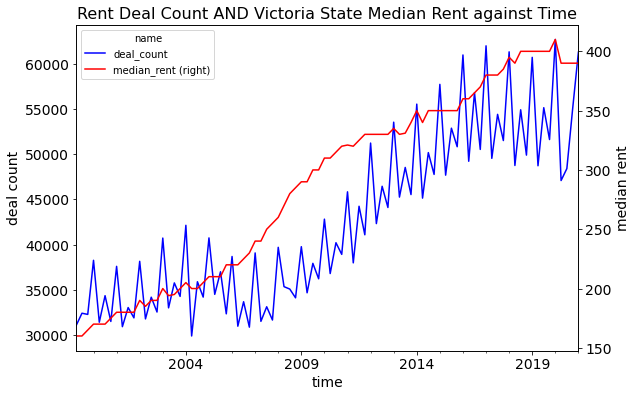

In [8]:
# read file
hisrent_df = pd.read_excel(f"../data/raw/DHHS/history_rent_quarterly.xlsx", sheet_name="All Properties")

# select data
hisrent_df = hisrent_df.loc[range(90, 91)]
hisrent_df = hisrent_df.T.reset_index(drop=True).T.drop([0], axis=1).dropna()
hisrent_df = hisrent_df.rename(columns={1: "name"})
hisrent_df = hisrent_df.set_index("name")
hisrent_df = hisrent_df.T.reset_index(drop=True)
num_year = int(hisrent_df.shape[0]/2)
hisrent_df = hisrent_df.T.replace("-", None).dropna()
hisrent_df = hisrent_df.astype(int)

# match time
year_list = range(1999, 2022)
quarter_list = [1, 2, 3, 4]
sec_list = [f"{i}-Q{j}" for i in year_list for j in quarter_list][1:-3]
sec_list = sorted(sec_list + sec_list)
sec_list = pd.PeriodIndex(sec_list, freq='Q').to_timestamp()
hisrent_df = hisrent_df.T
hisrent_df["time"] = sec_list
hisrent_df = hisrent_df.T

# select deal count
count_df = hisrent_df[[i*2 for i in range(num_year)]]
count_df = count_df.T.set_index("time", drop=True).rename(columns={"Victoria": "deal_count"})

# select median rent
median_df = hisrent_df[[i*2+1 for i in range(num_year)]]
median_df = median_df.T.set_index("time", drop=True).rename(columns={"Victoria": "median_rent"})

## plot median rent / deal count data
fig, ax = plt.subplots()
count_df.plot(ax = ax, figsize = (9,6), style='b-', fontsize=14)
plt.xlabel("Year & Quarter", fontsize=14)
plt.ylabel("deal count", fontsize=14)

median_df.plot(ax = ax, figsize = (9,6), secondary_y = True, style='r-', fontsize=14)
plt.ylabel("median rent", fontsize=14)
plt.title("Rent Deal Count AND Victoria State Median Rent against Time", fontsize=16)
plt.savefig(f"{FIG_PATH}History_rent.png")


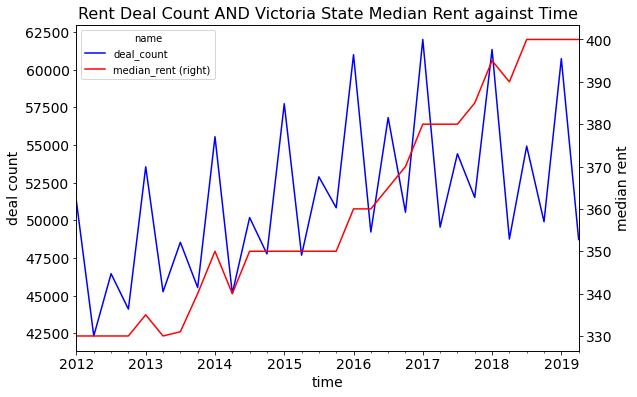

In [9]:
count_part = count_df.loc[count_df.index.to_list()[51:81]]
meidan_part = median_df.loc[median_df.index.to_list()[51:81]]

## plot median rent / deal count data
fig, ax = plt.subplots()
count_part.plot(ax = ax, figsize = (9,6), style='b-', fontsize=14)
plt.xlabel("Year & Quarter", fontsize=14)
plt.ylabel("deal count", fontsize=14)

meidan_part.plot(ax = ax, figsize = (9,6), secondary_y = True, style='r-', fontsize=14)
plt.ylabel("median rent", fontsize=14)
plt.title("Rent Deal Count AND Victoria State Median Rent against Time", fontsize=16)
plt.savefig(f"{FIG_PATH}Part_his_rent.png")

Property price index VS median rent

In [11]:
index_df = spark.read.csv(f"../data/raw/ABS/Price_index/Price_index.csv", header=True).toPandas()
index_df = index_df.dropna().drop_duplicates().astype(int)
index_df["time"] = index_df.apply(lambda x: str(int(x["year"]))+"-Q"+str(int(x["quarter"])), axis=1)
index_df["time"] = pd.PeriodIndex(index_df["time"], freq='Q').to_timestamp()
index_df =  index_df.drop(["year", "quarter"], axis=1).set_index("time", drop=True)

print(index_df.head())
print(median_df.head())

            price_index
time                   
2011-01-01          104
2011-04-01          103
2011-07-01          101
2011-10-01          100
2012-01-01           99
name       median_rent
time                  
1999-04-01         160
1999-07-01         160
1999-10-01         165
2000-01-01         170
2000-04-01         170


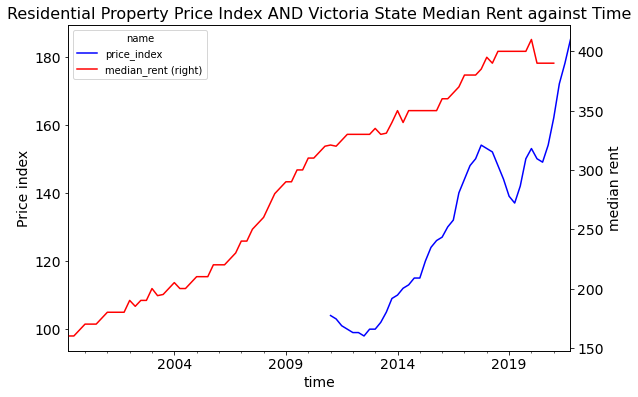

In [14]:
## plot median rent / deal count data
fig, ax = plt.subplots()
index_df.plot(ax = ax, figsize = (9,6), style='b-', fontsize=14)
plt.xlabel("Year & Quarter", fontsize=14)
plt.ylabel("Price index", fontsize=14)

median_df.plot(ax = ax, figsize = (9,6), secondary_y = True, style='r-', fontsize=14)
plt.ylabel("median rent", fontsize=14)
plt.title("Residential Property Price Index AND Victoria State Median Rent against Time", fontsize=16)
plt.savefig(f"{FIG_PATH}Price_Rent.png")

#### Quarter Data

(26, 3)
             bond  price_index  to_USD
time                                  
2013-07-01 2.9000     105.0000  0.9309
2013-10-01 2.9600     109.0000  0.8948
2014-01-01 2.9700     110.0000  0.9221
2014-04-01 2.8000     112.0000  0.9420
2014-07-01 2.8000     113.0000  0.8752


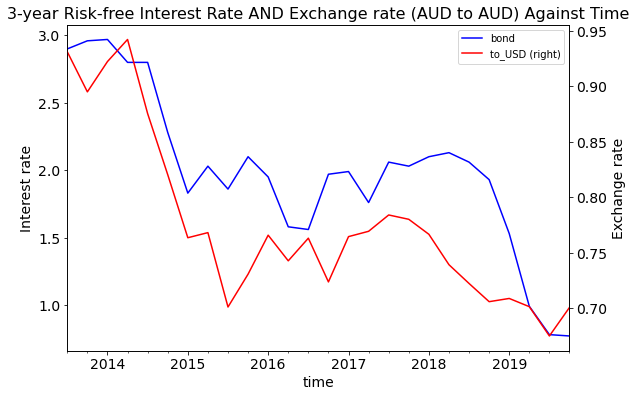

In [ ]:
## read data and feature selection
time_df = pd.read_csv("../data/curated/history_info.csv")
time_df = time_df[["year", "quarter", "bond", "price_index", "to_USD"]]
time_df = time_df.dropna().drop_duplicates()
time_df["time"] = time_df.apply(lambda x: str(int(x["year"]))+"-Q"+str(int(x["quarter"])), axis=1)
time_df["time"] = pd.PeriodIndex(time_df["time"], freq='Q').to_timestamp()
time_df =  time_df.drop(["year", "quarter"], axis=1).set_index("time", drop=True)

## plot data
fig, ax = plt.subplots()
time_df[["bond"]].plot(ax = ax, figsize = (9,6), style='b-', fontsize=14)
plt.xlabel("Year & Quarter", fontsize=14)
plt.ylabel("Interest rate", fontsize=14)

time_df[["to_USD"]].plot(ax = ax, figsize = (9,6), secondary_y = True, style='r-', fontsize=14)
plt.ylabel("Exchange rate", fontsize=14)
plt.title("3-year Risk-free Interest Rate AND Exchange rate (AUD to AUD) Against Time", fontsize=16)
plt.savefig(f"{FIG_PATH}Rate_Index.png")



print(time_df.shape)
print(time_df.head())

#### Year data

                     ratio
time                      
2009-01-01 12:00:00 0.9700
2011-01-01 12:00:00 0.8500
2013-01-01 12:00:00 0.8600
2015-01-01 12:00:00 0.8500
2017-01-01 12:00:00 1.1800
2019-01-01 12:00:00 1.1100


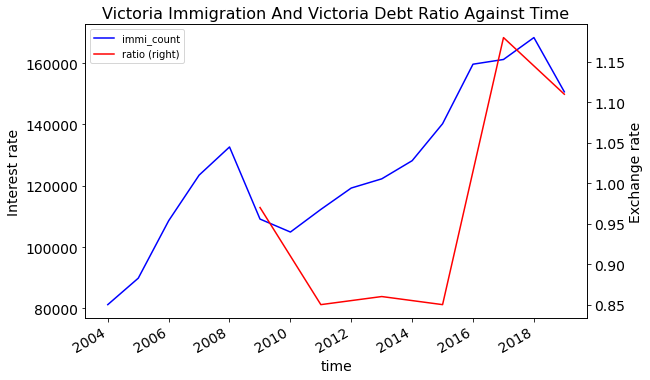

In [ ]:
## select immigration data
immigration_sdf = spark.read.csv(f"../data/raw/ABS/immigration/immigration.csv", header=True)
immi_df = immigration_sdf.toPandas()[['year', 'immi_count']]
immi_df = immi_df.astype(int)
immi_df = immi_df.sort_values(by=["year"]).reset_index(drop=True)
immi_df["time"] = immi_df["year"].apply(lambda x: pd.Timestamp(x, 1, 1, 12))
immi_df = immi_df.drop("year", axis=1).set_index("time")



## select ratio data
ratio_df = pd.read_excel(f"../data/raw/ABS/debt_income_ratio/debt_income_ratio.xlsx", sheet_name="Table 3.5")
ratio_df = ratio_df.loc[[4, 67]].set_axis(["time", "ratio"])
ratio_df = ratio_df.T.reset_index().drop(["index"], axis=1)
ratio_df = ratio_df.loc[range(8, 14)]
ratio_df["time"] = ratio_df["time"].apply(lambda x: int(x[:4]))
ratio_df["time"] = ratio_df["time"].apply(lambda x: pd.Timestamp(x, 1, 1, 12))
ratio_df = ratio_df.set_index("time")
print(ratio_df.head(50))




## plot data
fig, ax = plt.subplots()
immi_df.plot(ax = ax, figsize = (9,6), style='b-', fontsize=14)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Interest rate", fontsize=14)

ratio_df.plot(ax = ax, figsize = (9,6), secondary_y=True, sharex=True, style='r-', fontsize=14)
plt.ylabel("Exchange rate", fontsize=14)
plt.title("Victoria Immigration And Victoria Debt Ratio Against Time", fontsize=16)
plt.savefig(f"{FIG_PATH}year_data.png")
